# WEST ICRH Antenna RF Model
## The WEST ICRH antennas 
Three identical ELM-resilient and CW power ICRH antennas have been designed for WEST. The ELM resilience property is obtained through an internal conjugate-T electrical scheme with series capacitors. An antenna has 4 straps (2 toroidal x 2 poloidal) and is fed by 2 generators (left side and right side). Each antenna is equipped with four internal COMET® tuneable vacuum capacitors, with capacitances ranging from 15 pF to 150 pF and specifically upgraded for CW operation. A two-stage quarter-wavelength and water cooled impedance transformer is connected from the T-junction to the vacuum feedthrough.

<img src="West_Antenna_1.png" width="600"/>

<img src="West_Antenna_2.png" width="600"/>

## WEST IC antenna Python RF Model

In [2]:
%matplotlib notebook

In [3]:
%load_ext autoreload
%autoreload 2

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
from tqdm.notebook import tqdm
# WEST ICRH Antenna package
import sys; sys.path.append('..')
from west_ic_antenna import WestIcrhAntenna

The WEST ICRH Antenna RF model can be built be eventually defining:
- the frequency band of interest, given by a scikit-rf `Frequency` object
- the front face S-parameter `filename`, ie. the model of the antenna front-face radiating to a given medium
- the capacitor's capacitances `[C1, C2, C3, C4]`

All these parameters are optionnal when builing the `WestIcrhAntenna` object. Default parameters if a frequency band 30-70 MHz, with the front-face radiating in vacuum with all capacitances set to 50 pF.

In [5]:
# default values
antenna = WestIcrhAntenna()
print(antenna)

WEST ICRH Antenna: C=[50, 50, 50, 50] pF, 0.03-0.07 GHz, 4001 pts


For example, to reduce the frequency band of interest:

In [6]:
freq = rf.Frequency(48, 52, npoints=2001, unit='MHz')
antenna = WestIcrhAntenna(frequency=freq)

The antenna circuit can be visualized via the scikit-rf `Circuit` object:

<IPython.core.display.Javascript object>


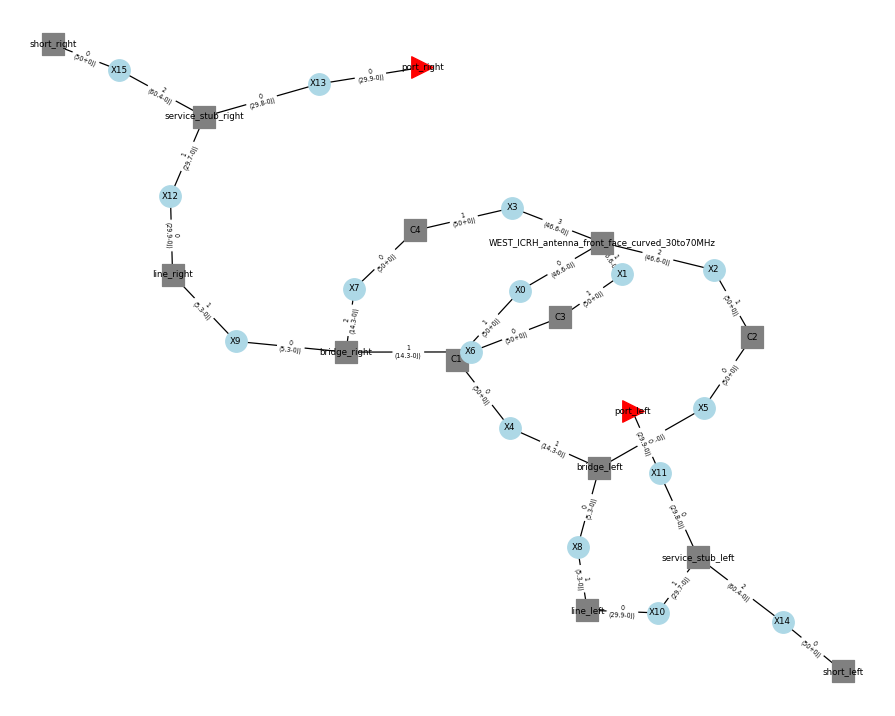

In [7]:
antenna.circuit().plot_graph(network_labels=True, edge_labels=True, 
inter_labels=True, port_labels=True)

## Antenna Matching
Matching the WEST ICRH antenna consists in setting up the 4 capacitances values ($C_1,C_2,C_3,C_4$) to achieve low reflected power to the generators (ideally zero from the generator point-of-view). For the given geometry of the WEST antenna, these optimal capacitances depend on:
- the antenna front-face, i.e. the plasma facing the antenna; 
- the antenna excitation, especially the phasing between left and right sides.


## Matching the antenna step by step
When both sides of the antenna are used (which is the desired situation), the figure of merit is not the reflection coefficient from scattering parameters (such as $S_{11}$ or $S_{22}$) but the "active" parameters, that is the RF parameters taking into account the antenna feeding and cross-coupling effects between both sides. Because of these cross-coupling effects, the matching point for each side used separately is not the same than for both sides used together.

Let's see step by step these effects.

Each side of the antenna can be matched separatly, which is what is done in practice since it's simpler to act on two capacitors than four at the same time. 

Let's start with the left side, looking for a solution at 50 MHz, with the solution 1 (corresponding to $C_{top} > C_{bot}$, solution 2 being the opposite). The right side is left unmatched.

In [8]:
f_match = 50e6
C_match_left = antenna.match_one_side(f_match=f_match, 
                                      side='left', solution_number=1)

Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [60.12955546 12.        ]
True solution #1: [67.52324254 64.61470494]


Once the solution has been found, we setup the antenna capacitors to these values: 

In [8]:
antenna.Cs = C_match_left

Let's have a look to the S-parameters of the antenna, which is a 2-port network. An easy way to plot them is to retrieve the scikit-rf `Network` object and its convenience methods:

<IPython.core.display.Javascript object>


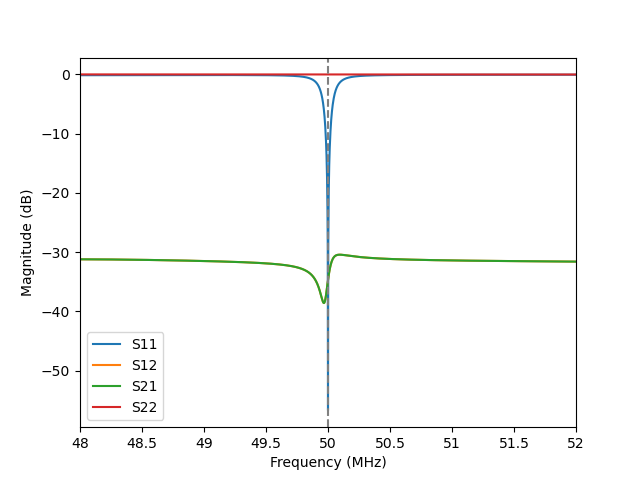

In [9]:
fig, ax = plt.subplots()
antenna.circuit().network.plot_s_db(ax=ax)
ax.axvline(f_match, color='gray', ls='--')

Now let's match the right side (the left side being unmatched). This time, it will minimize the S22 at the match frequency.

Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [59.94497972 12.        ]
True solution #1: [67.29026545 64.84061245]


<IPython.core.display.Javascript object>


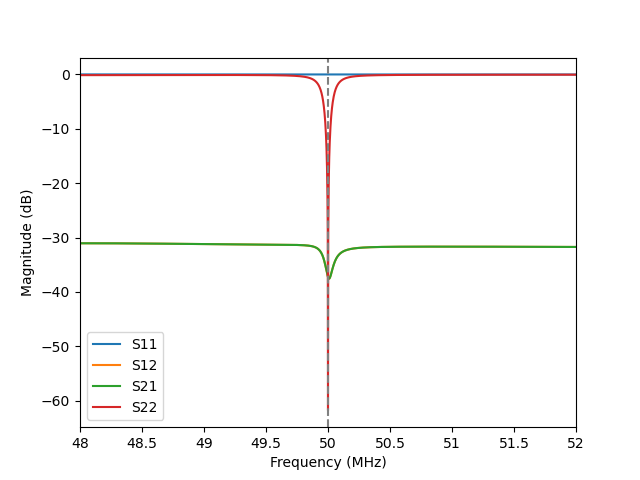

In [10]:
C_match_right = antenna.match_one_side(f_match=f_match, 
                                       side='right', solution_number=1)
antenna.Cs = C_match_right
fig, ax = plt.subplots()
antenna.circuit().network.plot_s_db(ax=ax)
ax.axvline(f_match, color='gray', ls='--')

If we setup the antenna with the combination of these two solutions, and zoom into the 48-52 MHz band, one sees that antenna shows two optimized frequencies around the match frequencies.

In [11]:
C_match = [C_match_left[0], C_match_left[1], C_match_right[2], C_match_right[3]]
print(C_match)
antenna.Cs = C_match

[67.52324351421422, 64.61470664290033, 67.2902654493288, 64.84061245363814]


<IPython.core.display.Javascript object>


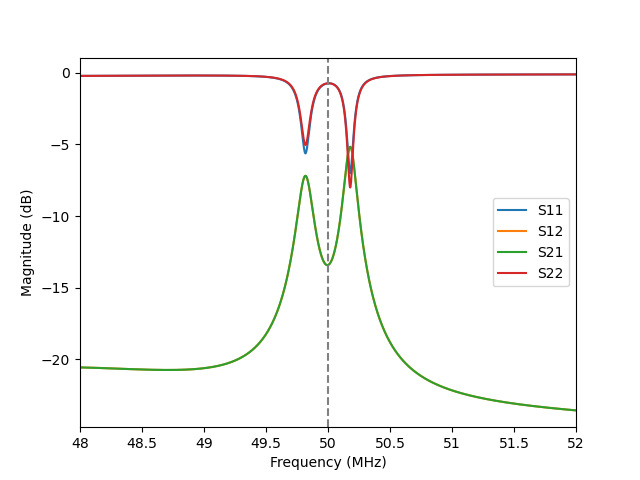

In [12]:
fig, ax = plt.subplots()
antenna.circuit(Cs=C_match).network.plot_s_db(ax=ax)
ax.axvline(f_match, color='gray', ls='--')

These optimum frequencies correspond to the monopole and dipole excitations. Instead of looking to the S-parameters, it is more meaningfull to look to the 'active' S-parameters, defined by:

$$
S_{act,m} = \sum_{n=1}^M S_{mn} \frac{a_n}{a_m}
$$

with $m=1..N$ where $N$ is the number of ports (here M=2) and $a_k$ the complex excitation for the k-th port.

<IPython.core.display.Javascript object>


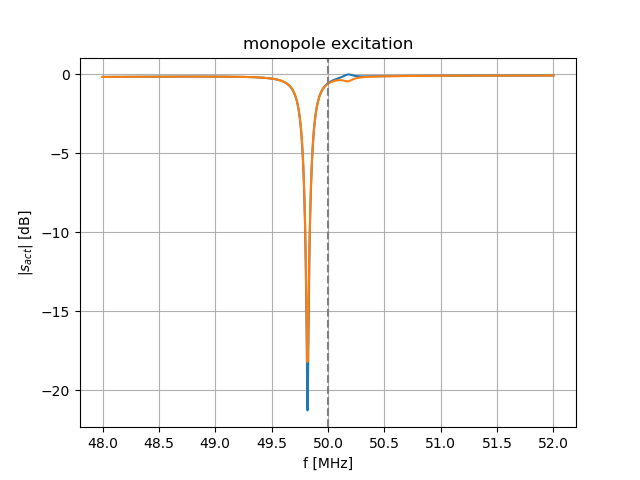

In [13]:
# monopole excitation, left side being the reference
power = [1, 1]
phase = [0, 0]
# getting the active s-parameters
s_act = antenna.s_act(power, phase)
# plotting
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)))
ax.axvline(f_match/1e6, ls='--', color='gray')
ax.set_title('monopole excitation')
ax.set_xlabel('f [MHz]')
ax.set_ylabel('$|s_{act}|$ [dB]')
ax.grid(True)

<IPython.core.display.Javascript object>


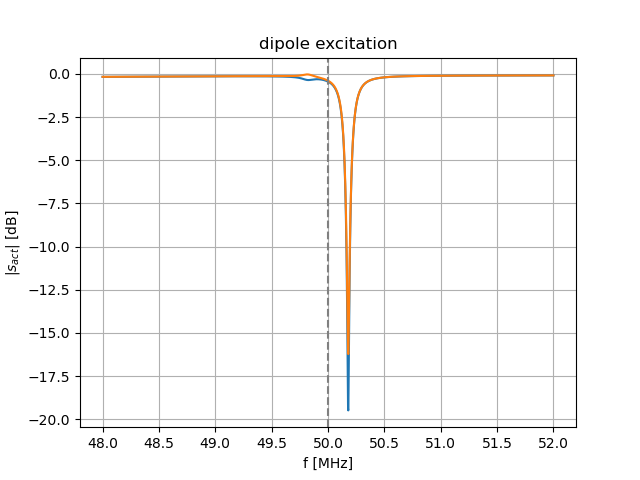

In [14]:
# dipole excitation, left side being the reference
power = [1, 1]
phase = [0, np.pi]
# getting the active s-parameters
s_act = antenna.s_act(power, phase, Cs=C_match)
# plotting
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)))
ax.axvline(f_match/1e6, ls='--', color='gray')
ax.set_title('dipole excitation')
ax.set_xlabel('f [MHz]')
ax.set_ylabel('$|s_{act}|$ [dB]')
ax.grid(True)

## Voltages and Currents

In [15]:
# dipole case, 1 MW input on both sides
power = [1e6, 1e6]
phase = [0, np.pi]

Vs = antenna.voltages(power, phase)
Is = antenna.currents(power, phase)

<IPython.core.display.Javascript object>


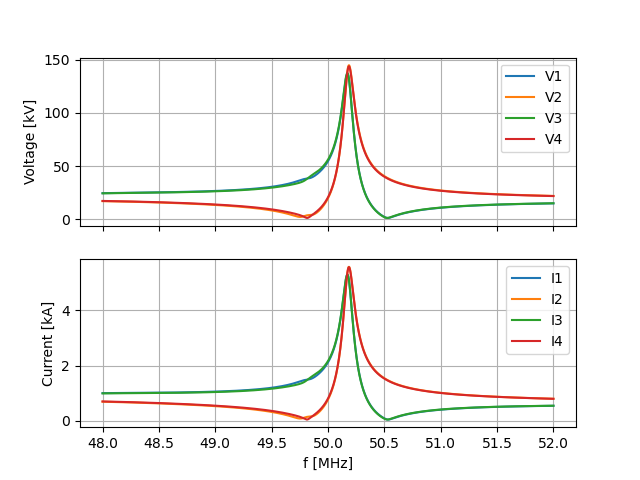

In [16]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(freq.f_scaled, np.abs(Vs)/1e3)
ax[1].plot(freq.f_scaled, np.abs(Is)/1e3)
ax[1].set_xlabel('f [MHz]')
ax[0].set_ylabel('Voltage [kV]')
ax[1].set_ylabel('Current [kA]')
[a.grid(True) for a in ax]
ax[0].legend(('V1','V2','V3','V4'))
ax[1].legend(('I1','I2','I3','I4'))

## Impedance at the T-junction
The WEST ICRH antennas design is based on the conjugate-T to insure a load-tolerance. In particular, they have been designed to operate with an impedance at the T-junction $Z_T$ close to 3 Ohm. An impedance transformer connects the T-junction to the feeding transmission line (30 Ohm line). Hence, matching the antenna is similar to having a 30 Ohm load connected to the feeding transmission line, such as no power is reflected (VSWR$\to 1$), which should be equivalent of having an impedance of 3 Ohm at the T-junction.

However, due to real-life design and manufacturing constraint, the optimal impedance at the T-junction is not necessarely 3 Ohm, but can be slightly different in both real and imginary parts. 

So let's evaluate the impact of the impedance at the T-junction to the 30Ohm feeder line (the one which really matter for the generator point-of-view).  

For that, let's take the impedance transformer/vacuum window/service stub network assembly of an antenna:

In [10]:
freq = rf.Frequency(50, 50, unit='MHz', npoints=1)
antenna = WestIcrhAntenna(frequency=freq)
assembly = antenna.windows_impedance_transformer
print(assembly)

2-Port Network: 'WEST_ICRH_Transf_Window_PumpHolePMC',  50.0-50.0 MHz, 1 pts, z0=[29.89491473-0.00316299j  5.2989722 -0.00376783j]


The port 1 of this network assembly corresponds to the 30 Ohm feeding line while the port 2 correspond to the end of the second section of the impedance transformer. Let's load the port 2 with an ideal impedance $Z_T=R_T + j X_T$ and scanning the effect of $R_T$ and $X_T$.

In [52]:
# create a grid of R_T and X_T values
R_Ts, X_Ts = np.meshgrid(np.linspace(1, 5, 50), 
                         np.linspace(-3, 3, 50))
media_port2 = rf.DefinedGammaZ0(frequency=freq, z0=assembly.z0[:,1])

In [53]:
# calculate the VSWR at port 1 as a function of (R_T, X_T)
vswrs = []
for (R_T,X_T) in tqdm(np.nditer([R_Ts, X_Ts])):
    Z_T = R_T + 1j*X_T
    # connect the port 2 with a impedance Z_T
    ntw = assembly ** media_port2.load(rf.zl_2_Gamma0(assembly.z0[:,1], Z_T))
    vswrs.append(float(ntw.s_vswr))
# reshape to 2D
vswrs = np.array(vswrs).reshape(R_Ts.shape)

<IPython.core.display.Javascript object>


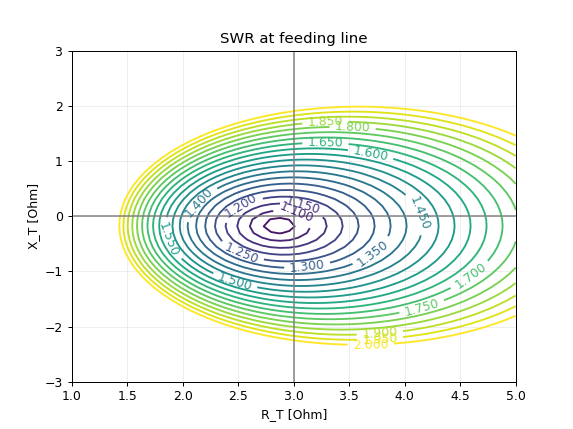

In [54]:
fig, ax = plt.subplots()
cs=ax.contour(R_Ts, X_Ts, vswrs, 
             np.linspace(1, 2, 21))
ax.clabel(cs, inline=1, fontsize=10)
ax.set_xlabel('R_T [Ohm]')
ax.set_ylabel('X_T [Ohm]')
ax.set_title('SWR at feeding line')
ax.axvline(3, color='gray', alpha=0.8)
ax.axhline(0, color='gray', alpha=0.8)
ax.grid(True, alpha=0.2)

Hence the optimal impedance at the T-junction is not 3 Ohm, but slightly above in the complex plane. Let's calculate this optimal value using: 

In [55]:
from scipy.optimize import minimize

In [62]:
def optim_fun(x):
    R_T, X_T = x
    Z_T = R_T + 1j*X_T
    # connect the port 2 with a impedance Z_T
    ntw = assembly ** media_port2.load(rf.zl_2_Gamma0(assembly.z0[:,1], Z_T))
    return float(ntw.s_vswr)

sol = minimize(optim_fun, x0=[3,0])
print('Optimum Z_T=', sol.x[0] + 1j*sol.x[1])

Optimum Z_T= (2.865529745505253-0.17120456652973623j)


The optimum T-impedance is such $Z_T= 2.87 - 0.17j$.

In [17]:
from IPython.core.display import HTML
def _set_css_style(css_file_path):
    """
    Read the custom CSS file and load it into Jupyter
    Pass the file path to the CSS file
    """
    styles = open(css_file_path, "r").read()
    s = '<style>%s</style>' % styles
    return HTML(s)

_set_css_style('custom.css')